In [1]:
import pandas as pd
import os
import numpy as np
import matplotlib.pyplot as plt
neues_verzeichnis = "C:\\Users\\Lucian\\Desktop\\WebMining_final"
os.chdir(neues_verzeichnis)

In [ ]:
df = pd.read_csv("filtered_games.csv")
genres = pd.read_csv("steam_game_genres_normalized.csv")


               steam_64_id   appid                                name  \
0        76561198144322955     570                              Dota 2   
1        76561198090414113     570                              Dota 2   
2        76561198071834270     570                              Dota 2   
3        76561198141513114     730                    Counter-Strike 2   
4        76561198262602149     570                              Dota 2   
...                    ...     ...                                 ...   
1402041  76561198251210208  641990                     The Escapists 2   
1402042  76561197982689005  266840  Age of Mythology: Extended Edition   
1402043  76561198049905605  343860                              Tacoma   
1402044  76561198119038836  360940   The Mean Greens - Plastic Warfare   
1402045  76561198178875206  347510         Rats - Time is running out!   

         playtime_forever  playtime_2weeks  has_community_visible_stats  
0                 1471505            

In [35]:
genres_clean = genres.dropna(subset=['genres'])
valid_appids = genres_clean['appid'].unique()

df_clean = df[df['appid'].isin(valid_appids)]

# Anzahl der einzigartigen Spieler
player_count = df_clean['steam_64_id'].nunique()

# Anzahl der einzigartigen Spiele
games_count = df_clean['appid'].nunique()

print("Anzahl der einzigartigen Spieler: ", player_count)
print("Anzahl der einzigartigen Spiele: ", games_count) 

Anzahl der Genres:  706
Anzahl der einzigartigen Spieler:  41623
Anzahl der einzigartigen Spiele:  9451


In [56]:
# Schritt 1: Berechne die Gesamtspielzeit für jedes Genre
df_genre_playtime = df_clean.merge(genres_clean, on="appid")
df_genre_playtime["genres"] = df_genre_playtime["genres"].str.split(",")  # Split Genres
df_genre_playtime = df_genre_playtime.explode("genres")  # Explode Genres
df_genre_playtime["genres"] = df_genre_playtime["genres"].str.strip()  # Strip Whitespaces

# Schritt 2: Berechne die Gesamtspielzeit für jedes Genre
genre_total_playtime = df_genre_playtime.groupby("genres")["playtime_forever"].sum()

# Schritt 3: Berechne die Gesamtspielzeit aller Spieler
total_playtime = df_clean["playtime_forever"].sum()

# Schritt 4: Berechne den neuen IDF-Wert für jedes Genre
genre_idf = np.log(total_playtime / genre_total_playtime)
genre_idf.sort_values(ascending=False, inplace=True)


# Schritt 5: In DataFrame umwandeln & ausgeben
df_genre_idf = genre_idf.reset_index()
df_genre_idf.columns = ["Genre", "IDF_Playtime"]  # Spalten sinnvoll benennen
print(df_genre_idf.sort_values(by="IDF_Playtime", ascending=False))
print(df_genre_idf.shape)



                    Genre  IDF_Playtime
0           Adult Content     11.573913
1                 Violent     11.100373
2        Software & Tools      6.025544
3      Media & Production      5.269049
4                  Racing      5.146920
5           Photo Editing      5.013400
6   Design & Illustration      4.681876
7            Early Access      4.514621
8               Utilities      4.291551
9                  Sports      4.071417
10                 Casual      3.473106
11             Simulation      2.858059
12                    MMO      2.452847
13                  Indie      2.352250
14                    RPG      2.307360
15              Adventure      1.830605
16               Strategy      0.530696
17           Free-to-Play      0.270781
18                 Action      0.097084
(19, 2)


In [58]:
# Spielzeit pro Genre für jeden Spieler berechnen
df_tf = df_genre_playtime.groupby(["steam_64_id", "genres"])["playtime_forever"].sum().reset_index()

# Gesamtspielzeit pro Spieler berechnen
total_playtime_per_player = df_clean.groupby("steam_64_id")["playtime_forever"].sum().reset_index()
total_playtime_per_player.rename(columns={"playtime_forever": "total_playtime"}, inplace=True)

# Mit der originalen TF-Tabelle zusammenführen
df_tf = df_tf.merge(total_playtime_per_player, on="steam_64_id")

# Relative TF berechnen (Spielzeit für ein Genre relativ zur gesamten Spielzeit des Spielers)
df_tf["TF_relative"] = df_tf["playtime_forever"] / df_tf["total_playtime"]

# Mit IDF-Werten verknüpfen
df_tf = df_tf.merge(df_genre_idf, left_on="genres", right_on="Genre", how="left")

# TF-IDF berechnen
df_tf["TF-IDF"] = df_tf["TF_relative"] * df_tf["IDF_Playtime"]

# Unnötige Spalten entfernen
df_tf.drop(columns=["playtime_forever", "total_playtime", "IDF_Playtime", "Genre"], inplace=True)

df_tf


,steam_64_id,genres,TF_relative,TF-IDF
0,76561197960359575,Action,0.665941,0.064652
1,76561197960359575,Adventure,0.374189,0.684993
2,76561197960359575,Casual,0.037773,0.131188
3,76561197960359575,Design & Illustration,0.006072,0.028428
4,76561197960359575,Early Access,0.045901,0.207225
...,...,...,...,...
409578,76561199806753268,Free-to-Play,1.000000,0.270781
409579,76561199806753268,Strategy,1.000000,0.530696
409580,76561199807600301,Action,1.000000,0.097084
409581,76561199807600301,Free-to-Play,1.000000,0.270781


In [60]:
# Spieler-Genre-Vektoren erstellen (Pivot-Tabelle)
df_player_tfidf = df_tf.pivot(index="steam_64_id", columns="genres", values="TF-IDF").fillna(0)

# Ergebnis anzeigen
print("TF-IDF Vektoren für Spieler-Genres erstellt")
print(df_player_tfidf)


TF-IDF Vektoren für Spieler-Genres erstellt
genres               Action  Adult Content  Adventure    Casual  \
steam_64_id                                                       
76561197960359575  0.064652            0.0   0.684993  0.131188   
76561197960471729  0.088356            0.0   0.613399  0.218527   
76561197960481035  0.077305            0.0   0.291845  0.028549   
76561197960493780  0.040503            0.0   0.031958  0.315537   
76561197960497152  0.076436            0.0   0.429658  0.237823   
...                     ...            ...        ...       ...   
76561199793735600  0.097084            0.0   0.000000  0.000000   
76561199793735604  0.097084            0.0   0.000000  0.000000   
76561199803373970  0.093405            0.0   0.069375  0.131621   
76561199806753268  0.097084            0.0   0.000000  0.000000   
76561199807600301  0.097084            0.0   0.000000  0.000000   

genres             Design & Illustration  Early Access  Free-to-Play  \
steam_64_id 

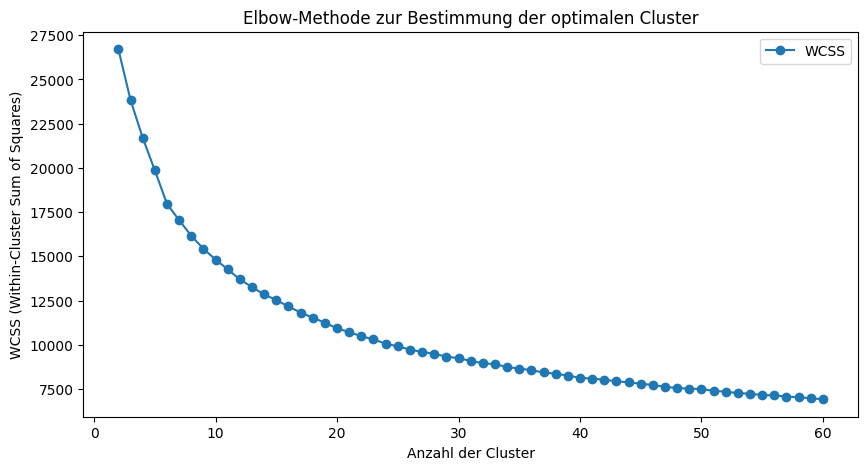

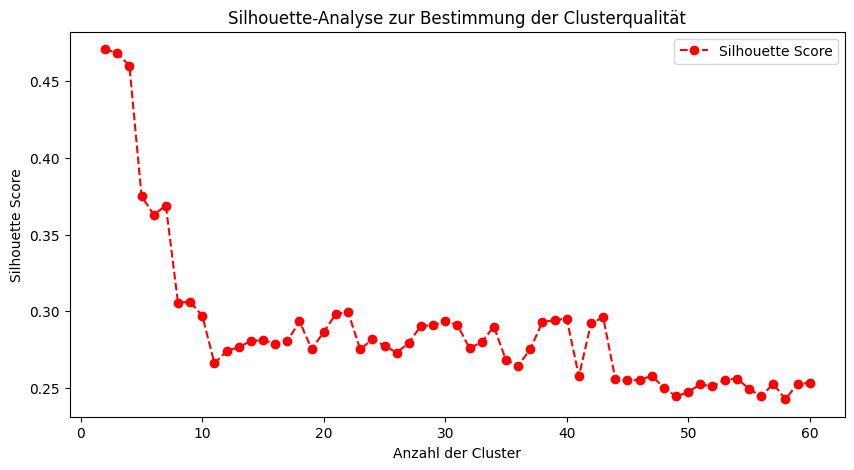

In [69]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import matplotlib.pyplot as plt

n_cluster = 61  # Maximale Anzahl an getesteten Clustern

wcss = []  # Liste für WCSS-Werte
silhouette_scores = []  # Liste für Silhouette-Scores
cluster_range = range(2, n_cluster)  # Cluster von 2 bis n_cluster testen

for k in cluster_range:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    cluster_labels = kmeans.fit_predict(df_player_tfidf)
    
    wcss.append(kmeans.inertia_)  # WCSS speichern
    silhouette_avg = silhouette_score(df_player_tfidf, cluster_labels)  # Silhouette Score berechnen
    silhouette_scores.append(silhouette_avg)  # Silhouette Score speichern

# Plot für Elbow-Methode (WCSS)
plt.figure(figsize=(10, 5))
plt.plot(cluster_range, wcss, marker='o', label="WCSS")
plt.xlabel("Anzahl der Cluster")
plt.ylabel("WCSS (Within-Cluster Sum of Squares)")
plt.title("Elbow-Methode zur Bestimmung der optimalen Cluster")
plt.legend()
plt.show()

# Plot für Silhouette-Score
plt.figure(figsize=(10, 5))
plt.plot(cluster_range, silhouette_scores, marker='o', linestyle='--', color='r', label="Silhouette Score")
plt.xlabel("Anzahl der Cluster")
plt.ylabel("Silhouette Score")
plt.title("Silhouette-Analyse zur Bestimmung der Clusterqualität")
plt.legend()
plt.show()


In [70]:
print(wcss)
print(silhouette_scores)

[26707.979882709576, 23838.319422406443, 21701.16990652938, 19863.71522552774, 17966.199292481117, 17042.40027158222, 16162.265952529724, 15424.72724750756, 14815.195099297578, 14259.784553160596, 13697.141068830799, 13256.608388171762, 12842.06142620478, 12526.498589205801, 12161.67200555034, 11821.691260137262, 11528.13986262851, 11248.988884794166, 10926.055521754755, 10713.72546720169, 10479.587097137484, 10302.9373783738, 10058.464123582244, 9909.41378832457, 9724.694951678295, 9591.640189304608, 9487.478017545041, 9328.323319854882, 9238.228972901341, 9085.147061836386, 8955.77735983875, 8899.488642333581, 8738.924775789876, 8655.191971334498, 8559.646752338727, 8430.347992504978, 8360.343829079686, 8253.712690661776, 8128.857803850319, 8081.737377036082, 8024.638641654455, 7927.143256556528, 7876.680687580645, 7792.667087514463, 7723.960855179037, 7616.723404747148, 7554.813583640947, 7516.4023774792895, 7494.09063618501, 7395.53230482548, 7345.844430234099, 7266.786226150287, 7

Clusteranzahl: 3, Silhouette Score: 0.4680
Clusteranzahl: 4, Silhouette Score: 0.4597
Clusteranzahl: 5, Silhouette Score: 0.3749
Clusteranzahl: 6, Silhouette Score: 0.3630
Clusteranzahl: 7, Silhouette Score: 0.3688


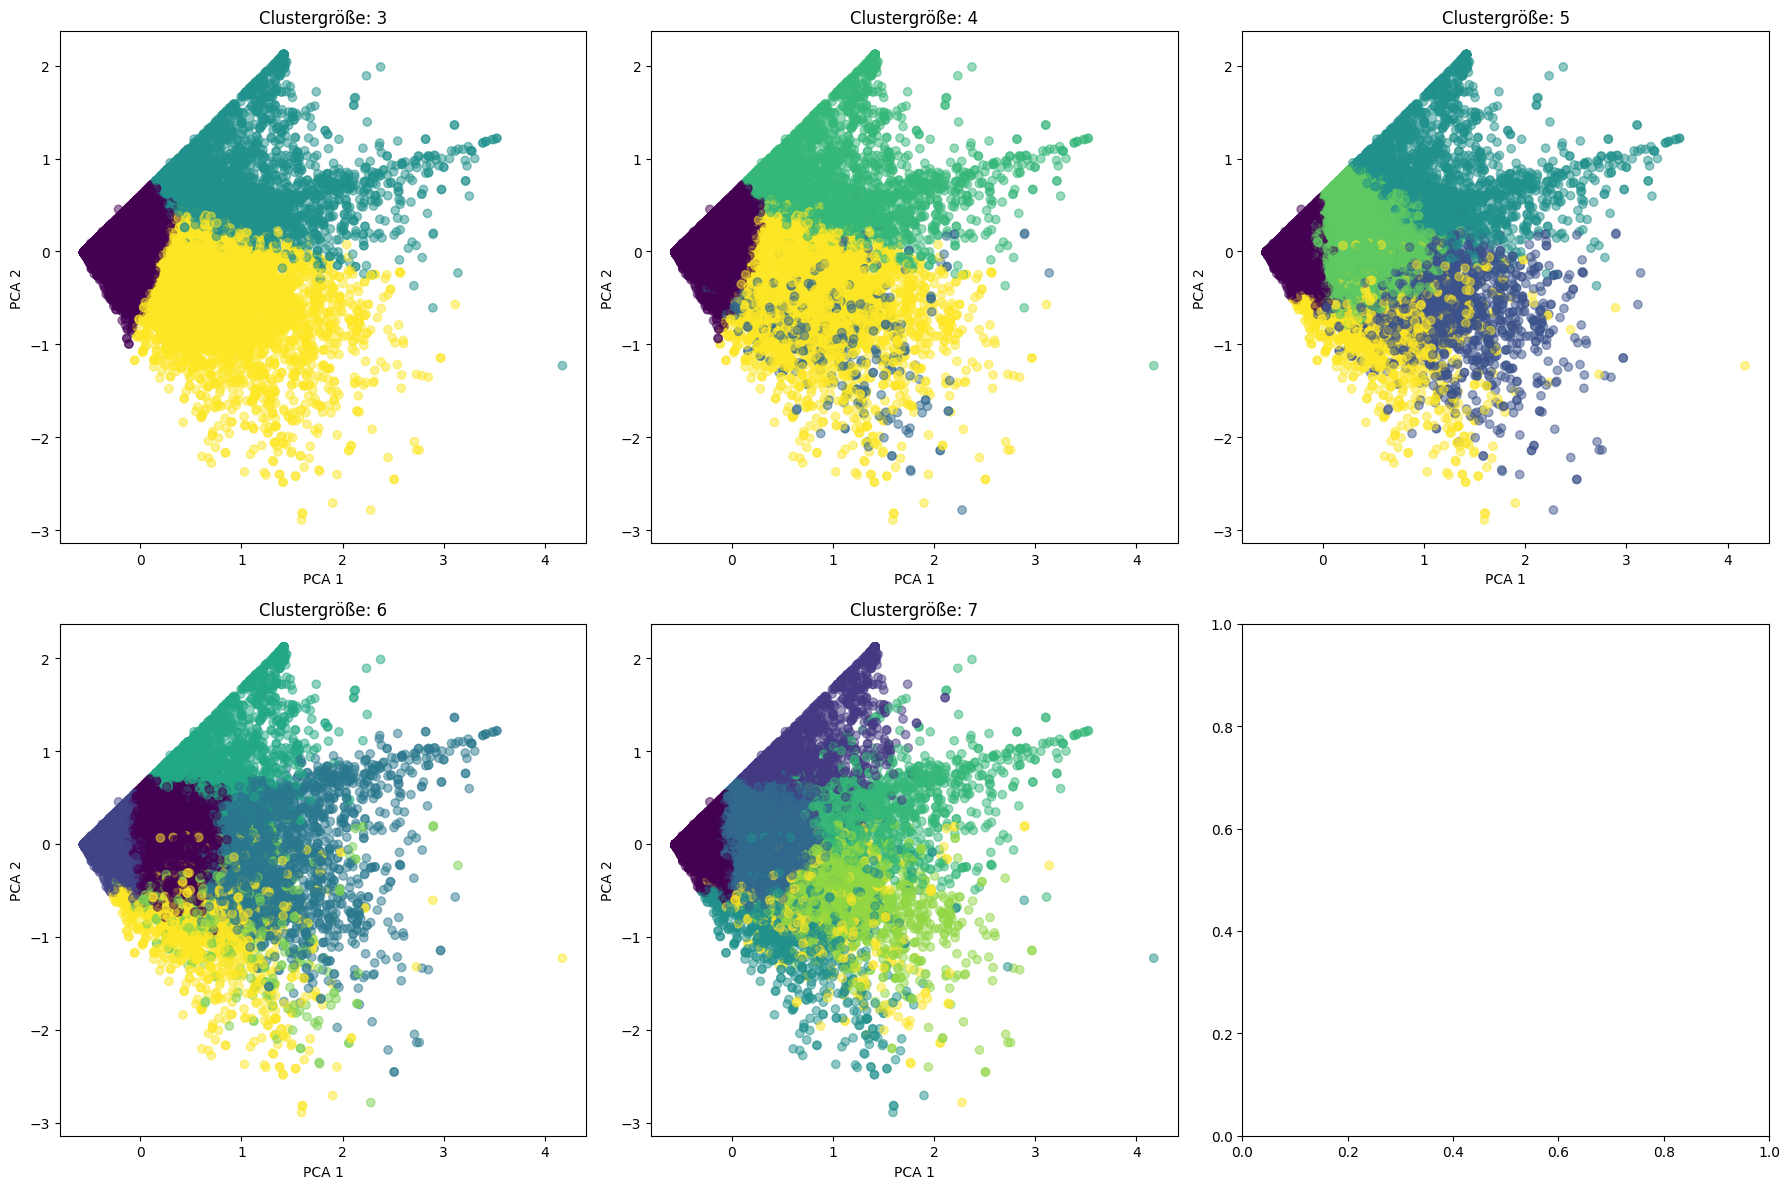

                                         F-Statistik  \
3  [12812.499753036289, 69.15733491180754, 28946....   
4  [9164.858792208457, 46.994912819509835, 19270....   
5  [8256.177889461414, 37.56551290266515, 21619.7...   
6  [6333.867884076868, 26.714583578964973, 17603....   
7  [6071.279026095456, 40.68432030803757, 14654.8...   

                                              p-Wert  
3  [0.0, 1.035493689459958e-30, 0.0, 0.0, 0.0, 0....  
4  [0.0, 2.606977856318457e-30, 0.0, 0.0, 0.0, 0....  
5  [0.0, 2.0407478144273863e-31, 0.0, 0.0, 0.0, 0...  
6  [0.0, 4.5974981910616096e-27, 0.0, 0.0, 0.0, 0...  
7  [0.0, 1.0521874625375368e-49, 0.0, 0.0, 0.0, 0...  


In [71]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score
from scipy.stats import f_oneway

# Clustergrößen definieren
cluster_sizes = range(3, 8)

# Ergebnisse speichern
cluster_results = {}

# Daten vorbereiten
df_features = df_player_tfidf.copy()  # Feature-Daten für Clustering

for k in cluster_sizes:
    # K-Means Clustering
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    cluster_labels = kmeans.fit_predict(df_features)

    # Clusterzentren speichern
    cluster_centers = pd.DataFrame(kmeans.cluster_centers_, columns=df_features.columns)

    # Silhouette Score berechnen
    silhouette_avg = silhouette_score(df_features, cluster_labels)

    # Ergebnisse speichern
    cluster_results[k] = {
        "labels": cluster_labels,
        "centers": cluster_centers,
        "silhouette_score": silhouette_avg
    }

    print(f"Clusteranzahl: {k}, Silhouette Score: {silhouette_avg:.4f}")

# Clusterverteilung visualisieren (PCA-Reduktion)
fig, axes = plt.subplots(2, 3, figsize=(18, 12))
axes = axes.flatten()

for i, k in enumerate(cluster_sizes):
    # PCA-Reduktion auf 2D
    pca = PCA(n_components=2)
    reduced_features = pca.fit_transform(df_features)
    
    # Scatterplot
    ax = axes[i]
    scatter = ax.scatter(reduced_features[:, 0], reduced_features[:, 1], c=cluster_results[k]["labels"], cmap="viridis", alpha=0.5)
    ax.set_title(f"Clustergröße: {k}")
    ax.set_xlabel("PCA 1")
    ax.set_ylabel("PCA 2")

plt.tight_layout()
plt.show()

# Varianzanalyse für Clustertrennung
anova_results = {}

for k in cluster_sizes:
    labels = cluster_results[k]["labels"]
    
    # Erstelle eine Liste mit Feature-Werten pro Cluster
    cluster_groups = [df_features.iloc[labels == c].values for c in range(k)]
    
    # F-Test durchführen
    f_stat, p_value = f_oneway(*cluster_groups)
    anova_results[k] = {"F-Statistik": f_stat, "p-Wert": p_value}

# Ergebnisse ausgeben
df_anova_results = pd.DataFrame(anova_results).T
print(df_anova_results)


In [80]:
type(df_player_tfidf)

pandas.core.frame.DataFrame

In [82]:
# Extrahiere die Labels für Clustergröße 3
cluster_3_labels = cluster_results[3]["labels"]

# Erstelle einen DataFrame mit Spieler-IDs und zugewiesenen Clustern
df_cluster_3 = df_player_tfidf.copy()
df_cluster_3["Cluster"] = cluster_3_labels

print(df_cluster_3) 




genres               Action  Adult Content  Adventure    Casual  \
steam_64_id                                                       
76561197960359575  0.064652            0.0   0.684993  0.131188   
76561197960471729  0.088356            0.0   0.613399  0.218527   
76561197960481035  0.077305            0.0   0.291845  0.028549   
76561197960493780  0.040503            0.0   0.031958  0.315537   
76561197960497152  0.076436            0.0   0.429658  0.237823   
...                     ...            ...        ...       ...   
76561199793735600  0.097084            0.0   0.000000  0.000000   
76561199793735604  0.097084            0.0   0.000000  0.000000   
76561199803373970  0.093405            0.0   0.069375  0.131621   
76561199806753268  0.097084            0.0   0.000000  0.000000   
76561199807600301  0.097084            0.0   0.000000  0.000000   

genres             Design & Illustration  Early Access  Free-to-Play  \
steam_64_id                                             

In [83]:
df_cluster_3 = df_cluster_3.reset_index()
print(df_cluster_3)

genres        steam_64_id    Action  Adult Content  Adventure    Casual  \
0       76561197960359575  0.064652            0.0   0.684993  0.131188   
1       76561197960471729  0.088356            0.0   0.613399  0.218527   
2       76561197960481035  0.077305            0.0   0.291845  0.028549   
3       76561197960493780  0.040503            0.0   0.031958  0.315537   
4       76561197960497152  0.076436            0.0   0.429658  0.237823   
...                   ...       ...            ...        ...       ...   
41618   76561199793735600  0.097084            0.0   0.000000  0.000000   
41619   76561199793735604  0.097084            0.0   0.000000  0.000000   
41620   76561199803373970  0.093405            0.0   0.069375  0.131621   
41621   76561199806753268  0.097084            0.0   0.000000  0.000000   
41622   76561199807600301  0.097084            0.0   0.000000  0.000000   

genres  Design & Illustration  Early Access  Free-to-Play     Indie       MMO  \
0                 

In [75]:
# Ausgabe der Cluster-Verteilung
print(df_cluster_3["Cluster"].value_counts())

Cluster
0    29802
2     8570
1     3251
Name: count, dtype: int64


In [76]:
cluster_3_centers = cluster_results[3]["centers"]
print(cluster_3_centers.T)  # Transponieren für bessere Übersicht


                              0         1         2
genres                                             
Action                 0.093152  0.089883  0.072945
Adult Content          0.000035  0.000043  0.000436
Adventure              0.140341  1.018622  0.550053
Casual                 0.046628  0.124266  0.315286
Design & Illustration  0.016369  0.045440  0.125615
Early Access           0.019504  0.079433  0.136016
Free-to-Play           0.240376  0.174703  0.117497
Indie                  0.077400  0.457213  0.628672
MMO                    0.099824  1.137585  0.231764
Media & Production     0.009502  0.020784  0.063279
Photo Editing          0.013649  0.044873  0.103825
RPG                    0.083047  0.523744  0.522355
Racing                 0.014610  0.030971  0.087524
Simulation             0.062832  0.170097  0.492589
Software & Tools       0.002692  0.025086  0.029058
Sports                 0.028760  0.041754  0.207533
Strategy               0.350378  0.114757  0.153710
Utilities   

In [77]:
# Berechnung der Durchschnittswerte pro Cluster
cluster_genre_means = df_cluster_3.groupby("Cluster").mean()

# Sortierung der stärksten Genre-Präferenzen pro Cluster
for cluster in range(3):
    print(f"\nCluster {cluster} - Top 5 Genre-Präferenzen:")
    print(cluster_genre_means.loc[cluster].sort_values(ascending=False).head(5))



Cluster 0 - Top 5 Genre-Präferenzen:
genres
Strategy        0.350346
Free-to-Play    0.240365
Adventure       0.140391
MMO             0.099863
Action          0.093151
Name: 0, dtype: float64

Cluster 1 - Top 5 Genre-Präferenzen:
genres
MMO             1.136825
Adventure       1.017613
RPG             0.523523
Indie           0.456913
Free-to-Play    0.174764
Name: 1, dtype: float64

Cluster 2 - Top 5 Genre-Präferenzen:
genres
Indie         0.629095
Adventure     0.550122
RPG           0.522565
Simulation    0.492865
Casual        0.315505
Name: 2, dtype: float64


In [84]:
df_cluster_3.to_csv("cluster_3_analysis.csv", index=False)
